# Quantifying simulation integration

### Some parts taken from comparing_across_clustering_methods

In [134]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib as mpl
import seaborn as sns
import scanpy as sc
import anndata as ad
import os

import umap

In [136]:
 # SETTINGS FOR ALL FIGURES, SCANPY, PROBABLY PYSCENIC AND SIMULATIONS

# scanpy mostly channels settings straight to matplotlib.rcParam, so to cleanly separate code we only 
# use scanpy's functionality for properties that do not get passed on to matplotlib.

# Set 'draw_all_as_vectors=True' if you want all dots in UMAP plots to be vectorial. This is considered
# *not* friendly as a big number of dots will hurt performance of Adobe and/or Inkscape.

def set_olfactory_bulb_figure_params(draw_all_as_vectors=False):
    """Function to ensure that general settings are set correctly at the start of creating a figure."""
    # This functions overwrites figure.figsize and sets it to a default of (4, 4) inches.
    sc.settings.set_figure_params(vector_friendly=not draw_all_as_vectors, frameon=False)

    # Matplotlib style settings
    # Figures on screen and written to file
    mpl.rcParams['figure.dpi'] = 100
    mpl.rcParams['figure.frameon'] = False
    mpl.rcParams['figure.autolayout'] = True
    mpl.rcParams['figure.constrained_layout.use'] = False
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['savefig.transparent'] = False
    mpl.rcParams['savefig.format'] = 'pdf'

    # Fonts
    # Copied from scanpy
    mpl.rcParams['font.sans-serif'] = [
            'Arial',
            'Helvetica',
            'DejaVu Sans',
            'Bitstream Vera Sans',
            'sans-serif',
        ]
# font size below includes names of clusters in the UMAP
    mpl.rcParams['font.size'] = 6.5
    mpl.rcParams['legend.fontsize'] = 7
    mpl.rcParams['axes.titlesize'] = 7
    #mpl.rcParams['axes.labelsize'] = 

    # Colour management
    # scanpy uses wisdom from https://graphicdesign.stackexchange.com/questions/3682/where-can-i-find-a-large-palette-set-of-contrasting-colors-for-coloring-many-d
    mpl.rcParams['axes.prop_cycle'] = cycler(color=sc.plotting.palettes.default_28)

# Several auxilary functions to clean up figures
def remove_labels(ax):
    """Remove x and y axis label and figure title."""
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

def set_frame_color(ax, color='grey'):
    """Set a frame color by assigning a color to each spine."""
    for sp in ['bottom', 'top', 'right', 'left']:
        ax.spines[sp].set_color(color)

In [154]:
st_folder = '../../OB_single_seq_data/final_nuclei/subcluster_tables'
#st_folder = 'D:Robin/Single_seq_data/final_nuclei/subcluster_tables'
STANDARD_TABLE_FNAME = os.path.join(st_folder,'st_table.p')
ST_MATRIX_FNAME = os.path.join(st_folder,'st_data.p')

sim_folder = '../../simulated-nuclei_data/OB_pyscenic/100_regulons/final_simulations/filtered_by_classifier'
#sim_folder = 'D:Robin/simulated-nuclei/100_regulons/final_simulations/subcluster_sim_filtered'
sim_table_fname = os.path.join(sim_folder,'sim_id_table.p')
sim_ex_mtx_fname = os.path.join(sim_folder,'sim_ex_mtx.p')

In [190]:
st_table = pickle.load(open(STANDARD_TABLE_FNAME,'rb'))
st_matrix = pickle.load(open(ST_MATRIX_FNAME,'rb'))

In [9]:
sim_table = pickle.load(open(sim_table_fname,'rb'))
sim_matrix = pickle.load(open(sim_ex_mtx_fname,'rb'))

In [4]:
sim_table.index

Index(['PCX_3_0', 'PCX_3_1', 'PCX_3_2', 'PCX_3_3', 'PCX_3_4', 'PCX_3_5',
       'PCX_3_6', 'PCX_3_7', 'PCX_3_9', 'PCX_3_10',
       ...
       'AON_2_2989', 'AON_2_2990', 'AON_2_2991', 'AON_2_2993', 'AON_2_2994',
       'AON_2_2995', 'AON_2_2996', 'AON_2_2997', 'AON_2_2998', 'AON_2_2999'],
      dtype='object', length=5438)

In [7]:
st_table.index

Index(['AAACGAAGTAGCGTCC-1', 'AAACGCTTCCCATAAG-1', 'AAACGCTTCTACCCAC-1',
       'AAAGAACCATCTGTTT-1', 'AAAGGATAGCACCGTC-1', 'AAAGGATTCAAACCTG-1',
       'AAAGGGCCAAGCGCAA-1', 'AAAGGGCTCGTAGCTA-1', 'AAAGGTACATAACTCG-1',
       'AAAGGTATCACGTCCT-1',
       ...
       'TTTCAGTAGCCGCTTG-1', 'TTTCAGTGTTCCAGGC-1', 'TTTCATGAGGTTGGAC-1',
       'TTTCATGAGTGGTTAA-1', 'TTTCCTCGTTAGAGTA-1', 'TTTGACTCATCGGAGA-1',
       'TTTGATCAGTTGTAGA-1', 'TTTGGTTGTGACATCT-1', 'TTTGTTGAGGCCTGAA-1',
       'TTTGTTGTCTCATTGT-1'],
      dtype='object', length=7504)

## filtering standard to for mitral or tufted only (optional) 

In [10]:
m_clusters2keep = ['M_1','M_2','M_3'] #mitral
t_clusters2keep = ['T1','PG/TE1','PG/TE2','TE1','TE2','TE3'] #tufted


m_names = [name for name in st_table.index if st_table.loc[name,'louvain'] in m_clusters2keep]

m_matrix = st_matrix.loc[m_names]   
m_table = st_table.loc[m_names] 

t_names = [name for name in st_table.index if st_table.loc[name,'louvain'] in t_clusters2keep]

t_matrix = st_matrix.loc[t_names]   
t_table = st_table.loc[t_names] 

m_table = m_table.replace({'M_1':'M1','M_2':'M2','M_3':'M3'})

## filtering simulations for only those that align with projection neurons (by UMAP coordinates)

In [113]:
#sim_folder = 'D:Robin/simulated-nuclei/100_regulons/final_simulations/subcluster_sim_filtered'
sim_table_fname = os.path.join(sim_folder,'sim_id_table.p')
sim_ex_mtx_fname = os.path.join(sim_folder,'sim_ex_mtx.p')

In [9]:
sim_table = pickle.load(open(sim_table_fname,'rb'))
sim_matrix = pickle.load(open(sim_ex_mtx_fname,'rb'))

In [140]:
full_folder = '../../simulated-nuclei_data/OB_pyscenic/no_PG/full'

fname = os.path.join(full_folder,'sim_st_Seurat_clusters.p')
full_clusters = pickle.load(open(fname,'rb'))

full_sim_table_fname = os.path.join(full_folder,'sim_id_table.p')
full_sim_ex_mtx_fname = os.path.join(full_folder,'sim_ex_mtx.p')

full_sim_table = pickle.load(open(sim_table_fname,'rb'))
full_sim_matrix = pickle.load(open(sim_ex_mtx_fname,'rb'))

In [13]:
#projection_sims = [cell for cell in sim_table.index if full_clusters.loc[cell,'seurat_clusters'] in ['4','5','6','14','15','24']]

In [141]:
fname = os.path.join(full_folder,'simulation_UMAP.p')
full_sim_umap = pickle.load(open(fname,'rb'))

In [145]:
len(full_sim_umap)

27000

In [146]:
full_sim_table

general_dataset specific_dataset
AON_1_34               AON            AON_1
AON_1_41               AON            AON_1
AON_1_53               AON            AON_1
AON_1_62               AON            AON_1
AON_1_64               AON            AON_1
...                    ...              ...
PCx_3_1488             PCx            PCx_3
PCx_3_1489             PCx            PCx_3
PCx_3_1490             PCx            PCx_3
PCx_3_1498             PCx            PCx_3
PCx_3_1499             PCx            PCx_3

[1899 rows x 2 columns]

In [ ]:
full_sim_table['umap0'] = full_sim_umap[:,0]
full_sim_table['umap1'] = full_sim_umap[:,1]

In [42]:
projection_sims = [cell for cell in sim_table.index if sim_table.loc[cell,'umap0'] < -4.7 or (sim_table.loc[cell,'umap0'] < -2.4 and sim_table.loc[cell,'umap1'] > 0)]

In [155]:
#tufted alignment only
projection_sims = [cell for cell in sim_table.index if sim_table.loc[cell,'umap0'] < -5]

In [156]:
len(projection_sims)

2542

In [157]:
projection_table = sim_table.loc[projection_sims]
projection_data = sim_matrix.loc[projection_sims]

In [160]:
new_folder = os.path.join(sim_folder,'tufted_aligned')

fname = os.path.join(new_folder,'sim_id_table.p')
projection_table.to_pickle(fname)

fname = os.path.join(new_folder,'sim_ex_mtx.p')
projection_data.to_pickle(fname)

In [161]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'general_dataset'] == 'PCx'])

1424

In [162]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'general_dataset'] == 'AON'])

1118

In [163]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'specific_dataset'] == 'PCx_1'])

255

In [164]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'specific_dataset'] == 'PCx_2'])

465

In [165]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'specific_dataset'] == 'PCx_3'])

704

In [166]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'specific_dataset'] == 'AON_1'])

393

In [167]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'specific_dataset'] == 'AON_2'])

251

In [168]:
len([cell for cell in projection_table.index if projection_table.loc[cell,'specific_dataset'] == 'AON_3'])

474

# Filtering for projectin neurons - using a classifier

In [147]:
%run simulation_quant_aid.py

In [188]:
full_folder = '../../simulated-nuclei_data/OB_pyscenic/no_PG/full'

#fname = os.path.join(full_folder,'standard_PCA.p')
#full_st_PCA = pickle.load(open(fname,'rb'))

fname = os.path.join('../../OB_single_seq_data','final_nuclei','full_tables_unscaled','st_table.p')
full_st_table = pickle.load(open(fname,'rb'))
full_st_table = full_st_table.loc[[index for index in full_st_table.index if full_st_table.loc[index,'included'] == '+']]

fname = os.path.join(full_folder,'sim_id_table.p')
full_sim_table = pickle.load(open(fname,'rb'))
fname = os.path.join(full_folder,'sim_ex_mtx.p')
full_sim_matrix = pickle.load(open(fname,'rb'))

In [189]:
full_st_table.index

Index(['AAACCCAAGAAGGATG_1', 'AAACCCAAGGTTGTTC_1', 'AAACCCACACATCATG_1',
       'AAACCCACACCAGGTC_1', 'AAACCCACAGCCTTCT_1', 'AAACCCAGTGGTCTAT_1',
       'AAACGAACAGACTCTA_1', 'AAACGAACATGACTGT_1', 'AAACGAAGTAGCGTCC_1',
       'AAACGAATCTCCGAAA_1',
       ...
       'TTTGGTTAGGAGACCT_3', 'TTTGGTTCATACACCA_3', 'TTTGGTTGTGACATCT_3',
       'TTTGGTTGTTATTCTC_3', 'TTTGGTTTCAGAATAG_3', 'TTTGGTTTCCGACGGT_3',
       'TTTGTTGAGCGTATGG_3', 'TTTGTTGAGGCCTGAA_3', 'TTTGTTGCATCGGATT_3',
       'TTTGTTGTCTCATTGT_3'],
      dtype='object', name='cellID', length=31703)

In [191]:
(full_sim_pca, full_st_pca) = read_sim_st_pca(full_folder,full_sim_table,full_st_table)

In [ ]:
full_st_PCA

In [192]:
clusters2keep = ['M1','M2','M3','T1','ET1','ET2','ET3','ET4']

names = [name for name in st_table.index if st_table.loc[name,'louvain'] in clusters2keep]
names_str = [name[0:-2] for name in names]

In [193]:
full_st_table['M/T'] = 'Rest'

In [194]:
for index in full_st_table.index:
    if full_st_table.loc[index,'subclustering'] == 'Subcluster Selection' and index[0:-2] in names_str:
        full_st_table.loc[index,'M/T'] = 'M/T'

In [197]:
len([index for index in full_st_table.index if full_st_table.loc[index,'M/T'] == 'M/T'])

6472

In [198]:
sim_dict = {'AON' : '#5E78FF', 'PCx' : '#9C6779'}

In [ ]:
#all subcluster vs. rest
(jaccard,matrix_results) = pca_lda_quant_classifier_matrixplot(full_st_pca,full_sim_pca,full_st_table,'subclustering',full_sim_table,'general_dataset',classify_by_names = ['Subcluster Selection','Rest'], results_color = {'Rest':'#d2d2cf','Subcluster Selection':'#4f5d75'},bar_colors = {'AON' : '#5E78FF', 'PCx' : '#9C6779'},group_by_names = ['AON','PCx'],num_runs=1000,save_folder=full_folder)

AxesSubplot(0.5,0.125;0.4x0.755)
[(0, 17999), (18000, 17999)]
27000
[<matplotlib.patches.Rectangle object at 0x127cc6950>, <matplotlib.patches.Rectangle object at 0x126247d10>]


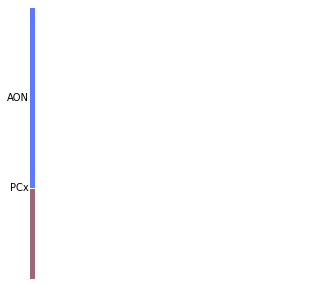

../../simulated-nuclei_data/OB_pyscenic/no_PG/full/LDA_matrix1000_runs.eps


In [ ]:
#M/T vs. rest
(jaccard,matrix_results) = pca_lda_quant_classifier_matrixplot(full_st_pca,full_sim_pca,full_st_table,'M/T',full_sim_table,'general_dataset',classify_by_names = ['M/T','Rest'], results_color = {'Rest':'#d2d2cf','M/T':'#4f5d75'},bar_colors = {'AON' : '#5E78FF', 'PCx' : '#9C6779'},group_by_names = ['AON','PCx'],num_runs=1000,save_folder=full_folder)

In [ ]:
matrix_results

In [ ]:
results_sum = matrix_results.sum(axis=1) #becuase subcluster_selection is 0, this is how many times it failed...

In [ ]:
threshold = (1-1)*1000

In [ ]:
threshold

In [ ]:
#what if I only take those who were classified as projection every single time
len([index for index in matrix_results.index if results_sum[index]<=threshold])

In [ ]:
len([index for index in matrix_results.index if (results_sum[index]<=threshold and index[0:3]=='PCx')])

In [ ]:
np.mean(jaccard)

In [ ]:
np.std(jaccard)

In [ ]:
projection_sims = [index for index in matrix_results.index if results_sum[index]<=0]

In [ ]:
len(projection_sims)

In [ ]:
projection_sims

In [ ]:
projection_table = full_sim_table.loc[projection_sims]
projection_data = full_sim_matrix.loc[projection_sims]

In [ ]:
new_folder = os.path.join('..','..','simulated-nuclei_data','OB_pyscenic','no_PG','filtered_by_classifier')
fname = os.path.join(new_folder,'sim_id_table.p')
projection_table.to_pickle(fname)

fname = os.path.join(new_folder,'sim_ex_mtx.p')
projection_data.to_pickle(fname)

# Better integrated UMAPs

In [182]:
# Auxilary function to convert from millimeter to inches
def mm_to_inches(x, y):
    return (x * 0.039370, y * 0.039370)

In [6]:
umap_folder = os.path.join(sim_folder,'mitral_new_colors')

#### First, only simulation

In [177]:
sim_umap = pickle.load(open(os.path.join(sim_folder,'simulation_UMAP.p'),'rb'))

In [178]:
sim_ad = sc.AnnData(sim_matrix)

In [179]:
sim_ad.obs = sim_table

In [180]:
sim_ad.obsm['X_umap'] = sim_umap

... storing 'general_dataset' as categorical
... storing 'specific_dataset' as categorical


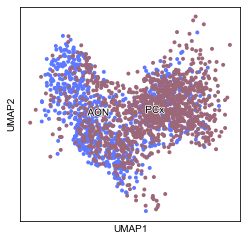

In [183]:

# UMAP CLUSTERS without frame around plot


# Settings for this figure
#best: Arial, font 7

mpl.rcParams['figure.figsize'] = mm_to_inches(100, 100)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 10 #Sara does 7, but I think 7 is hard to see...


ax = sc.pl.umap(sim_ad,  color='general_dataset', palette = ['#5E78FF','#9C6779'], title='',
                legend_fontweight='medium', legend_fontoutline=1.5,  legend_loc='on data',
                show=False)

#legend_fontweight=''
#‘light’, ‘normal’, ‘medium’, ‘semibold’, ‘bold’, ‘heavy’, ‘black’]

In [184]:
# Write UMAP to file.


# The file name (without extension) is 'full_umap.*' or 'subcluster_umap.*'
# Change extension between 'png', 'pdf' or 'svg'
#umap_output_fname = '{}_simulationumap.{}'.format(os.path.splitext(fname)[0], 'pdf')
umap_output_fname = os.path.join(sim_folder,'umap_simulations_only.png')

fig = ax.get_figure()
fig.tight_layout()
fig.savefig(umap_output_fname)

#### Next, standard in color, simulation in grey

In [186]:
full_umap = pickle.load(open(os.path.join(sim_folder,'sim_st_UMAP.p'),'rb')) #although counterintuitively named, this file has standard coordinates first, then simulation

In [187]:
len(full_umap)

4060

In [189]:
#I guess with the new regulons they are different shapes ?
st_matrix_sham = pd.DataFrame(0,index = m_matrix.index, columns = sim_matrix.columns)

In [197]:
full_ad = sc.AnnData(pd.concat([st_matrix_sham,sim_matrix]))

In [198]:
full_ad.obs = pd.concat([m_table,sim_table])

In [199]:
full_ad.obs['color'] = pd.concat([m_table['louvain'],sim_table['general_dataset']])

In [203]:
mitral = True

if mitral:
    cluster_colors = {
        'M2':'#d90368',
        'M1':'#fb8b24',
        'M3':'#f6bd60',
        'simulation_AON':'#5E78FF', 
        'simulation_PCX':'#9C6779'
    }
else: #tufted

    cluster_colors = {
        'T1':'#3700b3',
        'PG/TE2':'#bfadeb',
        'PG/TE1':'#ae25ba',
        'TE1':'#56cfe1',
        'TE2':'#219ebc',
        'TE3':'#846b8a',
        'PG':'#e637bf',
        'simulation_AON':'#5E78FF', 
        'simulation_PCX':'#9C6779'
    }

# WARNING in anndata 0.7.3 this color field is sometimes (accidentally)
# deleted by scanpy methods. Stay at version 0.7.1 to avoid this problem.
full_ad.uns['color_colors'] = [cluster_colors[key] for key in sorted(cluster_colors.keys())]

In [201]:
full_ad.obsm['X_umap'] = full_umap

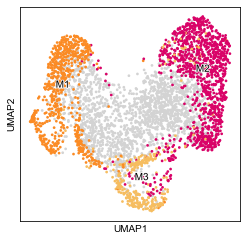

In [206]:

# UMAP CLUSTERS without frame around plot


# Settings for this figure
#best: Arial, font 7

mpl.rcParams['figure.figsize'] = mm_to_inches(100, 100)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 10 #Sara does 7, but I think 15 is better (7 looks kind of hard to see...)


ax = sc.pl.umap(full_ad,  color='color', groups = ['M1','M2','M3'], title='',
                palette = ['#f6bd60','#fb8b24','#d90368' ], #mitral - not sure why the order has to be weird
                #palette = ['#aa4465','#d999b9','#a663cc','#ef476f','#bf0603','#846b8a'], #tufted (again, got the order through trial and error)

                legend_fontweight='medium', legend_fontoutline=1.5,  legend_loc='on data',
                show=False)

#legend_fontweight=''
#‘light’, ‘normal’, ‘medium’, ‘semibold’, ‘bold’, ‘heavy’, ‘black’]

In [207]:
# Write UMAP to file.


# The file name (without extension) is 'full_umap.*' or 'subcluster_umap.*'
# Change extension between 'png', 'pdf' or 'svg'
#umap_output_fname = '{}_mitralumap.{}'.format(os.path.splitext(fname)[0], 'pdf')
umap_output_fname = os.path.join(sim_folder,'mitral_umap_combined.png')

fig = ax.get_figure()
fig.tight_layout()
fig.savefig(umap_output_fname)

# Full umap (only simulations in color) to show filtering

In [221]:
st_folder = os.path.join('../../OB_single_seq_data','final_nuclei','full_tables')
STANDARD_TABLE_FNAME = os.path.join(st_folder,'st_table.p')
ST_MATRIX_FNAME = os.path.join(st_folder,'st_data.p')

#sim_folder = '../../simulated-nuclei_data/OB_pyscenic/final_regulons/good_replicates/sctransform/subcluster_sim_filtered'
sim_folder = '../../simulated-nuclei_data/OB_pyscenic/100_regulons/final_simulations/full_take_two'
sim_table_fname = os.path.join(sim_folder,'sim_id_table.p')
sim_ex_mtx_fname = os.path.join(sim_folder,'sim_ex_mtx.p')

In [222]:
full_st_table = pickle.load(open(STANDARD_TABLE_FNAME,'rb'))
full_st_matrix = pickle.load(open(ST_MATRIX_FNAME,'rb'))

In [220]:
full_sim_table = pickle.load(open(sim_table_fname,'rb'))
full_sim_matrix = pickle.load(open(sim_ex_mtx_fname,'rb'))

In [223]:
full_sim_table

general_dataset specific_dataset
PCx_1_0                PCx            PCx_1
PCx_1_1                PCx            PCx_1
PCx_1_2                PCx            PCx_1
PCx_1_3                PCx            PCx_1
PCx_1_4                PCx            PCx_1
...                    ...              ...
AON_3_2995             AON            AON_3
AON_3_2996             AON            AON_3
AON_3_2997             AON            AON_3
AON_3_2998             AON            AON_3
AON_3_2999             AON            AON_3

[13500 rows x 2 columns]

In [ ]:
full_clusters.index

In [208]:
full_umap = pickle.load(open(os.path.join(full_folder,'sim_st_UMAP.p'),'rb')) #although counterintuitively named, this file has standard coordinates first, then simulation

In [209]:
len(full_umap)

45203

In [224]:
full_ad = sc.AnnData(pd.concat([full_st_matrix,full_sim_matrix]))

//anaconda3/envs/robin_simulations/lib/python3.7/site-packages/anndata/utils.py:88: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


In [225]:
full_st_matrix = full_st_matrix[[col for col in full_st_matrix.columns if col in full_sim_matrix]]

In [226]:
full_ad.obs = pd.concat([full_st_table,full_sim_table])

In [230]:
full_st_table.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleID', 'percent.mt',
       'included', 'nCount_SCT', 'nFeature_SCT', 'all', 'DF_Classification',
       'DF_pANN', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7',
       'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15',
       'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'UMAP_1', 'UMAP_2',
       'tSNE_1', 'tSNE_2', 'cellIdent', 'hmIdent2', 'hmIdent', 'clustIdent',
       'subclustering', 'sub_clusters_ExNeurons',
       'sub_clusters_ExNeurons_names', 'UMAP_1_sub_clusters_ExNeurons',
       'UMAP_2_sub_clusters_ExNeurons', 'sub_subclustering',
       'sub_sub_clusters_ExNeurons', 'sub_sub_clusters_ExNeurons_names',
       'UMAP_1_sub_sub_clusters_ExNeurons',
       'UMAP_2_sub_sub_clusters_ExNeurons'],
      dtype='object')

In [246]:
full_sim_table['subclustering'] = full_sim_table['general_dataset']+'_non-projection'
full_sim_table.loc[projection_sims,'subclustering'] = full_sim_table.loc[projection_sims,'general_dataset']+'_projection'

In [249]:
full_ad.obs['projection'] = pd.concat([full_st_table['subclustering'],full_sim_table['subclustering']])

In [254]:
full_ad.obs['projection'].unique()

[Rest, Subcluster Selection, PCx_non-projection, PCx_projection, AON_non-projection, AON_projection]
Categories (6, object): [Rest, Subcluster Selection, PCx_non-projection, PCx_projection, AON_non-projection, AON_projection]

In [266]:
#simulations (full set)
color_dict = {
    'Subcluster Selection':'#d2d2cf',
    'Rest':'#d2d2cf',
    'AON_projection' : '#5E78FF', 
    'AON_non-projection':'#5E78FF',
    'PCx_projection' : '#9C6779',
    'PCx_non-projection' : '#9C6779',    
}

full_ad.uns['projection_colors'] = [color_dict[key] for key in sorted(color_dict.keys())]

In [269]:
#subcluster vs. rest (training set)
color_dict = {
    'Subcluster Selection':'#4f5d75',
    'Rest':'#d2d2cf',
    'AON_projection' : '#d2d2cf', 
    'AON_non-projection':'#d2d2cf',
    'PCx_projection' : '#d2d2cf',
    'PCx_non-projection' : '#d2d2cf',    
}

full_ad.uns['projection_colors'] = [color_dict[key] for key in sorted(color_dict.keys())]

In [272]:
#only selected simulations
color_dict = {
    'Subcluster Selection':'#d2d2cf',
    'Rest':'#d2d2cf',
    'AON_projection' : '#5E78FF', 
    'AON_non-projection':'#d2d2cf',
    'PCx_projection' : '#9C6779',
    'PCx_non-projection' : '#d2d2cf',    
}

full_ad.uns['projection_colors'] = [color_dict[key] for key in sorted(color_dict.keys())]

In [256]:
full_ad.obsm['X_umap'] = full_umap

In [273]:

# UMAP CLUSTERS without frame around plot

#'simulation_AON':'#5E78FF', 
#'simulation_PCX':'#9C6779'

# Settings for this figure
#best: Arial, font 7

mpl.rcParams['figure.figsize'] = mm_to_inches(100, 100)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 10 #Sara does 7, but I think 15 is better (7 looks kind of hard to see...)


ax = sc.pl.umap(full_ad,  color='projection', 
                #groups = ['Subcluster Selection','simulated_projection','simulated_non-projection'], 
                title='',
                #palette = ['#9C6779','#4f5d75','#5E78FF'], 
                legend_fontweight='medium', legend_fontoutline=1.5,  legend_loc='None',
                show=False)


#legend_fontweight=''
#‘light’, ‘normal’, ‘medium’, ‘semibold’, ‘bold’, ‘heavy’, ‘black’]

In [117]:

# UMAP CLUSTERS without frame around plot

#'simulation_AON':'#5E78FF', 
#'simulation_PCX':'#9C6779'

# Settings for this figure
#best: Arial, font 7

mpl.rcParams['figure.figsize'] = mm_to_inches(100, 100)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.size'] = 10 #Sara does 7, but I think 15 is better (7 looks kind of hard to see...)


ax = sc.pl.umap(full_ad,  color='filter', groups = ['AON','PCx','MT'], title='',
                palette = ['#5E78FF','#7E7E77','#9C6779'], 
                legend_fontweight='medium', legend_fontoutline=1.5,  legend_loc='None',
                show=False)

#add filter lines
ax.axvline(x=-2.4,ymin=0.5,ymax=1,color='black')
ax.axvline(x=-4.7,ymin=0,ymax=0.5,color='black')
ax.axhline(y=-0.2,xmin=0.7/3,xmax=1.1/3,color='black')


#legend_fontweight=''
#‘light’, ‘normal’, ‘medium’, ‘semibold’, ‘bold’, ‘heavy’, ‘black’]

In [274]:
# Write UMAP to file.


# The file name (without extension) is 'full_umap.*' or 'subcluster_umap.*'
# Change extension between 'png', 'pdf' or 'svg'
#umap_output_fname = '{}_mitralumap.{}'.format(os.path.splitext(fname)[0], 'pdf')
umap_output_fname = os.path.join(sim_folder,'full_umap_only_selected_sim.png')

fig = ax.get_figure()
fig.tight_layout()
fig.savefig(umap_output_fname)

# Quantifying UMAP overlap (voting)

#### currently built for outputs of sctransform, not scVI

In [10]:
%run simulation_quant_aid.py

In [106]:
mitral_folder = os.path.join(sim_folder,'mitral')

In [143]:
umap_votes(mitral_folder,sim_table,'general_dataset',st_table,'louvain',sim_names = ['AON','PCx'], st_names = ['M1','M2','M3'])

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

In [144]:
pca_votes(mitral_folder,sim_table,'general_dataset',st_table,'louvain',sim_names = ['AON','PCx'], st_names = ['M1','M2','M3'])

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

### Load data from scVI (obsolete for now)

In [ ]:
scvi_folder = os.path.join(SIM_FOLDER,'1000_epochs_mitral_only')

In [ ]:
#scvi
st_table['umap0'] = st_table['umap0']
st_table['umap1'] = st_table['umap1']

sim_table['umap0'] = sim_table['umap0']
sim_table['umap1'] = sim_table['umap1']

# Linear Discriminant Analysis (LDA)

### train on simulations --> then test classify standard as either AON or PCX

In [56]:
pca_lda(mitral_folder,sim_table,'general_dataset',m_table,'louvain', sim_names = ['AON','PCx'], st_names = ['M_1','M_2','M_3'])

(          AON       PCx
 M_1  0.963557  0.036443
 M_2  0.086162  0.913838
 M_3  0.411043  0.588957,
           AON       PCx
 AON  0.969863  0.030137
 PCx  0.066838  0.933162)

<Figure size 432x288 with 0 Axes>

In [146]:
st_dict = {'M1' : '#fb8b24', 'M2' : '#d90368', 'M3' : '#f6bd60'}
sim_dict = {'AON' : '#5E78FF', 'PCx' : '#9C6779'}

quant_classifier(sim_folder,sim_table,'general_dataset',m_table,'louvain', sim_names = ['AON','PCx'], st_names = ['M1','M2','M3'],
                         results_color=st_dict,conf_color=sim_dict,num_runs=10)

TypeError: quant_classifier() got an unexpected keyword argument 'sim_names'

In [149]:
# SETTINGS FOR ALL FIGURES, SCANPY, PROBABLY PYSCENIC AND SIMULATIONS (from Anton)

# scanpy mostly channels settings straight to matplotlib.rcParam, so to cleanly separate code we only 
# use scanpy's functionality for properties that do not get passed on to matplotlib.

# Set 'draw_all_as_vectors=True' if you want all dots in UMAP plots to be vectorial. This is considered
# *not* friendly as a big number of dots will hurt performance of Adobe and/or Inkscape.

def set_olfactory_bulb_figure_params(draw_all_as_vectors=False):
    """Function to ensure that general settings are set correctly at the start of creating a figure."""
    # This functions overwrites figure.figsize and sets it to a default of (4, 4) inches.
    sc.settings.set_figure_params(vector_friendly=not draw_all_as_vectors, frameon=False)

    # Matplotlib style settings
    # Figures on screen and written to file
    mpl.rcParams['figure.dpi'] = 100
    mpl.rcParams['figure.frameon'] = False
    mpl.rcParams['figure.autolayout'] = True
    mpl.rcParams['figure.constrained_layout.use'] = False
    mpl.rcParams['savefig.dpi'] = 600
    mpl.rcParams['savefig.transparent'] = False
    mpl.rcParams['savefig.format'] = 'pdf'

    # Fonts
    # Copied from scanpy
    mpl.rcParams['font.sans-serif'] = [
            'Arial',
            'Helvetica',
            'DejaVu Sans',
            'Bitstream Vera Sans',
            'sans-serif',
        ]

    mpl.rcParams['font.size'] = 7
    mpl.rcParams['legend.fontsize'] = 7
    mpl.rcParams['axes.titlesize'] = 7
    mpl.rcParams['axes.labelsize'] = 5

    # Colour management
    # scanpy uses wisdom from https://graphicdesign.stackexchange.com/questions/3682/where-can-i-find-a-large-palette-set-of-contrasting-colors-for-coloring-many-d

# Several auxilary functions to clean up figures
def remove_labels(ax):
    """Remove x and y axis label and figure title."""
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')

def set_frame_color(ax, color='grey'):
    """Set a frame color by assigning a color to each spine."""
    for sp in ['bottom', 'top', 'right', 'left']:
        ax.spines[sp].set_color(color)

In [151]:
# Auxilary functions to convert from millimeter(s) to inch(es). Matplotlib figure dimensions are in inches.
def mm_to_inch(x):
    return x * 0.039370

def mm_to_inches(x, y):
    return (x * 0.039370, y * 0.039370)

set_olfactory_bulb_figure_params()
mpl.rcParams['figure.figsize'] = mm_to_inches(100, 100)
mpl.rcParams['figure.autolayout'] = False

# Uncomment the 4 lines of code below to remove the frame around the heatmap
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True

In [58]:
%run simulation_quant_aid.py

In [18]:
m_table = m_table.replace({'M_1':'M1','M_2':'M2','M_3':'M3'})

In [12]:
st_dict = {'M1' : '#fb8b24', 'M2' : '#d90368', 'M3' : '#f6bd60'}
sim_dict = {'AON' : '#5E78FF', 'PCx' : '#9C6779'}

In [162]:
(sim_pca,st_pca) = read_sim_st_pca(sim_folder,sim_table,m_table)

(integration_jaccard,classifier_results) = pca_lda_quant_classifier_matrixplot(sim_pca,st_pca,sim_table,'general_dataset',m_table,'louvain', classify_by_names = ['AON','PCx'], group_by_names = ['M1','M2','M3'],
                                                         results_color=sim_dict, bar_colors=st_dict,num_runs=1000,save_folder=sim_folder)

AxesSubplot(0.5,0.125;0.4x0.755)
[(0, 685), (686, 1834), (1835, 2160)]
2161
[<matplotlib.patches.Rectangle object at 0x1347538d0>, <matplotlib.patches.Rectangle object at 0x12316c810>, <matplotlib.patches.Rectangle object at 0x174ce0650>]


<Figure size 432x288 with 0 Axes>

In [6]:
fname = os.path.join(sim_folder,'classifier_results_matrix.p')
classifier_results = pickle.load(open(fname,'rb'))

AxesSubplot(0.5,0.125;0.4x0.755)
[(0, 685), (686, 1834), (1835, 2160)]
2161
[<matplotlib.patches.Rectangle object at 0x125454b10>, <matplotlib.patches.Rectangle object at 0x12411b610>, <matplotlib.patches.Rectangle object at 0x12b0f9290>]


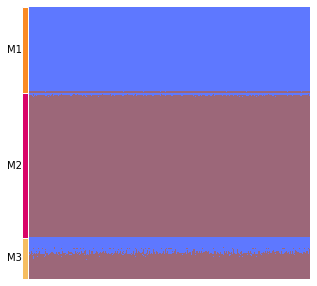

../../simulated-nuclei_data/OB_pyscenic/100_regulons/final_simulations/filtered_by_classifier/LDA_matrix1000_runs.eps


<Figure size 432x288 with 0 Axes>

In [19]:
plot_matrixplot(classifier_results,sim_table,'general_dataset',m_table,'louvain', classify_by_names = ['AON','PCx'], group_by_names = ['M1','M2','M3'],
                                                         results_color=sim_dict, bar_colors=st_dict,num_runs=1000,save_folder=sim_folder)

In [289]:
fname = os.path.join(sim_folder,'classifier_results_matrix.p')
classifier_results.to_pickle(fname)

In [163]:
np.mean(integration_jaccard)

0.8568042105263157

In [164]:
np.std(integration_jaccard)

0.014131582044496377

In [21]:
classifier_results_sum = classifier_results[range(0,1000)].sum(axis=1)

In [282]:
#quanitifying M1
print('% M1 always AON')
len([index for index in classifier_results.index if (classifier_results_sum[index] == 0 and 
                                                     classifier_results.loc[index,'louvain'] is 'M1')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M1'])

% M1 always AON


0.9752186588921283

In [22]:
#quanitifying M2
print('% M1 always PCx')
len([index for index in classifier_results.index if (classifier_results_sum[index] == 1000 and 
                                                     classifier_results.loc[index,'louvain'] is 'M1')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M1'])

% M1 always PCx


0.014577259475218658

In [284]:
#quanitifying M2
print('% M2 always PCx')
len([index for index in classifier_results.index if (classifier_results_sum[index] == 1000 and 
                                                     classifier_results.loc[index,'louvain'] is 'M2')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M2'])

% M2 always PCx


0.9721496953872933

In [285]:
#quanitifying M3
print('% M3 always AON')
len([index for index in classifier_results.index if (classifier_results_sum[index] == 0 and 
                                                     classifier_results.loc[index,'louvain'] is 'M3')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M3'])

% M3 always AON


0.21779141104294478

In [286]:
#quanitifying M3
print('% M3 always PCx')
len([index for index in classifier_results.index if (classifier_results_sum[index] == 1000 and 
                                                     classifier_results.loc[index,'louvain'] is 'M3')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M3'])

% M3 always PCx


0.450920245398773

In [287]:
#quanitifying M3
print('% M3 AON 90+ % of time')
len([index for index in classifier_results.index if (classifier_results_sum[index] <= 100 and 
                                                     classifier_results.loc[index,'louvain'] is 'M3')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M3'])

% M3 AON 90+ % of time


0.3006134969325153

In [288]:
#quanitifying M3
print('% M3 PCx 90+ % of time')
len([index for index in classifier_results.index if (classifier_results_sum[index] >= 900 and 
                                                     classifier_results.loc[index,'louvain'] is 'M3')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M3'])

% M3 PCx 90+ % of time


0.5644171779141104

In [23]:
#quanitifying M3
print('% M1 AON 90+ % of time')
len([index for index in classifier_results.index if (classifier_results_sum[index] <= 100 and 
                                                     classifier_results.loc[index,'louvain'] is 'M1')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M1'])

% M1 AON 90+ % of time


0.978134110787172

In [24]:
#quanitifying M3
print('% M1 PCx 90+ % of time')
len([index for index in classifier_results.index if (classifier_results_sum[index] >= 900 and 
                                                     classifier_results.loc[index,'louvain'] is 'M1')]) / len([index for index in classifier_results.index if classifier_results.loc[index,'louvain'] is 'M1'])

% M1 PCx 90+ % of time


0.016034985422740525

### using (even further) subclustering

In [29]:
fname = os.path.join(st_folder,'subclustering_seurat.csv')
granular_table = pd.read_csv(fname,sep = '\t')

In [31]:
granular_table = granular_table.set_index('Unnamed: 0')

In [32]:
granular_table

louvain
Unnamed: 0                
AAACGAAGTAGCGTCC-1     T1e
AAACGCTTCCCATAAG-1     T1e
AAACGCTTCTACCCAC-1     ET2
AAAGAACCATCTGTTT-1     T1a
AAAGGATAGCACCGTC-1     T1b
...                    ...
TTTGACTCATCGGAGA-1     T1e
TTTGATCAGTTGTAGA-1     T1a
TTTGGTTGTGACATCT-1     M2a
TTTGTTGAGGCCTGAA-1     T1a
TTTGTTGTCTCATTGT-1     ET2

[6472 rows x 1 columns]

In [43]:
m3_names = [name for name in m_table.index if m_table.loc[name,'louvain'] is 'M3']

m3_matrix = m_matrix.loc[m3_names]   
m3_table = m_table.loc[m3_names] 

In [45]:
m3_table['granular'] = granular_table

In [47]:
m3_table.granular

AACCATGAGTGTTGAA-1    M3a
AAGCGAGGTGTAGCAG-1    M3b
AATGAAGTCAAGTGGG-1    M3b
ACCCTCAGTCTGATCA-1    M3b
ACGGTTATCGCTAATG-1    M3b
                     ... 
TGGTAGTAGTATTAGG-1    M3a
TGTGATGGTGCATACT-1    M3b
TGTTCATTCCCGTAAA-1    M3a
TTACGCCTCAACTTTC-1    M3b
TTCGCTGGTTATCCAG-1    M3a
Name: granular, Length: 326, dtype: object

In [52]:
(sim_pca,st_pca) = read_sim_st_pca(sim_folder,sim_table,m_table)
m3_pca = st_pca.loc[m3_names]

In [53]:
m3_dict = {'M3a' : '#F6C679', 'M3b' : '#F4AE3E'} #colors selected by going above and below M3 on coolors
sim_dict = {'AON' : '#5E78FF', 'PCx' : '#9C6779'}

In [59]:
(m3_jaccard,m3_classifier_results) = pca_lda_quant_classifier_matrixplot(sim_pca,m3_pca,sim_table,'general_dataset',m3_table,'granular', classify_by_names = ['AON','PCx'], group_by_names = ['M3a','M3b'],
                                                         results_color=sim_dict, bar_colors=m3_dict,num_runs=1000,save_folder=sim_folder,save_name='M3_granular_1000_LDA.eps')

AxesSubplot(0.5,0.125;0.4x0.755)
[(0, 165), (166, 325)]
326
[<matplotlib.patches.Rectangle object at 0x1253a6410>, <matplotlib.patches.Rectangle object at 0x1243bdf90>]


../../simulated-nuclei_data/OB_pyscenic/100_regulons/final_simulations/filtered_by_classifier/M3_granular_1000_LDA.eps


<Figure size 432x288 with 0 Axes>

In [61]:
m3_classifier_results_sum = m3_classifier_results[range(0,1000)].sum(axis=1)

In [64]:
m3_classifier_results

0  1  2  3  4  5  6  7  8  9  ...  991  992  993  994  \
AGCTACACACTGGCCA-1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0   
AGGAGGTGTATGGTAA-1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0   
CGTAGTATCCCAGGCA-1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0   
GAGTTTGGTGAATAAC-1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0   
TCTCAGCAGGAGTACC-1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0   
...                .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...   
TCAAGCATCCTATTGT-1  1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1   
TCACGGGGTGCCCTTT-1  1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1   
TCCCACATCATCGGGC-1  1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1   
TGTGATGGTGCATACT-1  1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1   
TTACGCCTCAACTTTC-1  1  1  1  1  1  1  1  1  1  1  ...    1    1    1    1   

                    995  996  997  998  999  granular  
AGCTACACACTGGCCA-1    0    0    0    0    0       M3a  
AGGAGGTGTATGGTAA-1    0    0    0    0    0       M3a  
CGTAGTATCCCAGGCA-1    0    0    0    0    0       M3a  
GAGTTTGGTGAATAAC-1    0    0    0    0    0       M3a  
TCTCAGCAGGAGTACC-1    0    0    0    0    0       M3a  
...                 ...  ...  ...  ...  ...       ...  
TCAAGCATCCTATTGT-1    1    1    1    1    1       M3b  
TCACGGGGTGCCCTTT-1    1    1    1    1    1       M3b  
TCCCACATCATCGGGC-1    1    1    1    1    1       M3b  
TGTGATGGTGCATACT-1    1    1    1    1    1       M3b  
TTACGCCTCAACTTTC-1    1    1    1    1    1       M3b  

[326 rows x 1001 columns]

In [77]:
#quanitifying M3
print('% M3a always AON')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] == 0 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3a')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3a'])

% M3a always AON


0.3253012048192771

In [78]:
#quanitifying M3
print('% M3a always PCx')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] == 1000 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3a')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3a'])

% M3a always PCx


0.4036144578313253

In [79]:
#quanitifying M3
print('% M3b always AON')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] == 0 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3b')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3b'])

% M3b always AON


0.0875

In [80]:
#quanitifying M3
print('% M3b always PCx')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] == 1000 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3b')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3b'])

% M3b always PCx


0.5375

In [81]:
#quanitifying M3
print('% M3a AON 90%')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] <= 100 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3a')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3a'])

% M3a AON 90%


0.4036144578313253

In [82]:
#quanitifying M3
print('% M3a 90% PCx')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] >= 900 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3a')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3a'])

% M3a 90% PCx


0.4879518072289157

In [83]:
#quanitifying M3
print('% M3b 90% AON')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] <= 100 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3b')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3b'])

% M3b 90% AON


0.19375

In [84]:
#quanitifying M3
print('% M3b 90% PCx')
len([index for index in m3_classifier_results.index if (m3_classifier_results_sum[index] >= 900 and 
                                                     m3_classifier_results.loc[index,'granular'] == 'M3b')]) / len([index for index in m3_classifier_results.index if m3_classifier_results.loc[index,'granular'] == 'M3b'])

% M3b 90% PCx


0.64375

In [88]:
sorted(granular_table.louvain.unique())

['ET1a',
 'ET1b',
 'ET1c',
 'ET1d',
 'ET1e',
 'ET2',
 'ET3',
 'ET4a',
 'ET4b',
 'ET4c',
 'M1a',
 'M1b',
 'M1c',
 'M1d',
 'M1e',
 'M2a',
 'M2b',
 'M3a',
 'M3b',
 'T1a',
 'T1b',
 'T1c',
 'T1d',
 'T1e']

## Trying XGBoost!

In [113]:
%run simulation_quant_aid.py

In [24]:
#apparently have to use numerical values --> AON=0, PCx=1 
sim_table_int = sim_table.replace({'AON':0,'PCx':1})

In [ ]:
sim_table_int

In [ ]:
run_xgboost(sim_matrix,m_matrix,sim_table_int,'general_dataset',m_table,'louvain',classify_by_names = None, group_by_names = ['M1','M2','M3'], figure = True, save_folder = None)

In [114]:
quant_classifier('XGBoost',sim_matrix,m_matrix,sim_table_int,'general_dataset',m_table,'louvain', classify_by_names = None, group_by_names = ['M1','M2','M3'],save_folder=mitral_folder,num_runs=100)

medians:  classified as  true label
0              0             95.918178
               1              4.619450
1              0              4.081822
               1             95.380550
Name: %, dtype: float64


<Figure size 432x288 with 0 Axes>

medians:  classified as  known label
0              M1             19.023324
               M2             12.880766
               M3             37.423313
1              M1             80.976676
               M2             87.119234
               M3             62.576687
Name: %, dtype: float64


<Figure size 432x288 with 0 Axes>

In [115]:
#what about XGBoost on PCA (embedded low-dimensional space)
(sim_pca,m_pca) = read_sim_st_pca(mitral_folder,sim_table,m_table)

quant_classifier('XGBoost',sim_pca,m_pca,sim_table_int,'general_dataset',m_table,'louvain', classify_by_names = None, group_by_names = ['M1','M2','M3'],save_folder=mitral_folder,num_runs=100)

medians:  classified as  true label
0              0             92.308197
               1              8.279062
1              0              7.691803
               1             91.720938
Name: %, dtype: float64


<Figure size 432x288 with 0 Axes>

medians:  classified as  known label
0              M1             95.043732
               M2             11.575283
               M3             47.392638
1              M1              4.956268
               M2             88.424717
               M3             52.607362
Name: %, dtype: float64


<Figure size 432x288 with 0 Axes>

#### plotting those classifier results on STANDARD umap

In [32]:
classifier_results = classifier_results.assign(mean=classifier_results.mean(axis=1))

In [38]:
##read in data
data_path_robin = '../../OB_single_seq_data/final_nuclei'

fname = os.path.join(data_path_robin,'subcluster.loom') # only excitatory neurons

data = ad.read_loom(fname, sparse=False)

## set cluster names
data.obs['louvain'] = data.obs.louvain.replace({
    '0':'T1',
    '1':'M2',
    '2':'PG/TE2',
    '3':'PG/TE1',
    '4':'TE1',
    '5':'M1',
    '6':'TE2',
    '7':'M3',
    '8':'TE3',
    '9':'PG'})

#New colors
cluster_colors = {
    'T1':'#3700b3',
    'M2':'#d90368',
    'PG/TE2':'#bfadeb',
    'PG/TE1':'#ae25ba',
    'TE1':'#56cfe1',
    'M1':'#fb8b24',
    'TE2':'#219ebc',
    'M3':'#f6bd60',
    'TE3':'#846b8a',
    'PG':'#e637bf'
}



# WARNING in anndata 0.7.3 this color field is sometimes (accidentally)
# deleted by scanpy methods. Stay at version 0.7.1 to avoid this problem.
data.uns['louvain_colors'] = [cluster_colors[key] for key in sorted(cluster_colors.keys())]

#umap for reference
ax = sc.pl.umap(data,  color='louvain', title='',
                legend_fontweight='light', size=10, legend_fontoutline=2.5,  legend_loc='on data',
                show=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'DF_Classification' as categorical
... storing 'all' as categorical
... storing 'cellIdent' as categorical
... storing 'clustIdent' as categorical
... storing 'hmIdent2' as categorical
... storing 'included' as categorical
... storing 'louvain' as categorical
... storing 'orig.ident' as categorical
... storing 'sampleID' as categorical
... storing 'sub_clusters_ExNeurons_names' as categorical
... storing 'sub_sub_clusters_ExNeurons_names' as categorical
... storing 'sub_subclustering' as categorical
... storing 'subclustering' as categorical


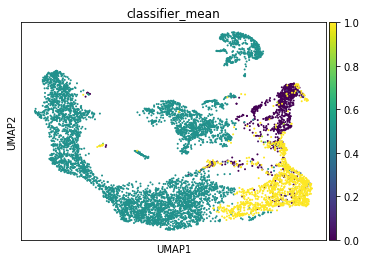

In [53]:
#plotting classifier results
data.obs['classifier_mean'] = classifier_results['mean']
data.obs['classifier_mean'] = data.obs['classifier_mean'].replace({np.nan:0.5})

ax = sc.pl.umap(data,  color='classifier_mean')

In [52]:
data.obs['classifier_mean'].replace({np.nan:0.5})

AAACGAAGTAGCGTCC-1    0.5
AAACGCTTCCCATAAG-1    0.5
AAACGCTTCTACCCAC-1    0.5
AAAGAACCATCTGTTT-1    0.5
AAAGGATAGCACCGTC-1    0.5
                     ... 
TTTGACTCATCGGAGA-1    0.5
TTTGATCAGTTGTAGA-1    0.5
TTTGGTTGTGACATCT-1    1.0
TTTGTTGAGGCCTGAA-1    0.5
TTTGTTGTCTCATTGT-1    0.5
Name: classifier_mean, Length: 7504, dtype: float64

In [196]:
#tufted


#tufted_folder = os.path.join(sim_folder,'tufted')
tufted_folder = umap_folder

umap_votes(tufted_folder,sim_table,'general_dataset',st_table,'louvain',sim_names = ['AON','PCx'], st_names = ['T-middle_1','PG/T-ext','T-ext_1','T-middle_2','T-ext_2','T-ext_3'])

pca_votes(tufted_folder,sim_table,'general_dataset',st_table,'louvain',sim_names = ['AON','PCx'], st_names = ['T-middle_1','PG/T-ext','T-ext_1','T-middle_2','T-ext_2','T-ext_3'])

pca_lda(tufted_folder,sim_table,'general_dataset',st_table,'louvain', sim_names = ['AON','PCx'], st_names = ['T-middle_1','PG/T-ext','T-ext_1','T-middle_2','T-ext_2','T-ext_3'])

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

<Figure size 283.464x283.464 with 0 Axes>

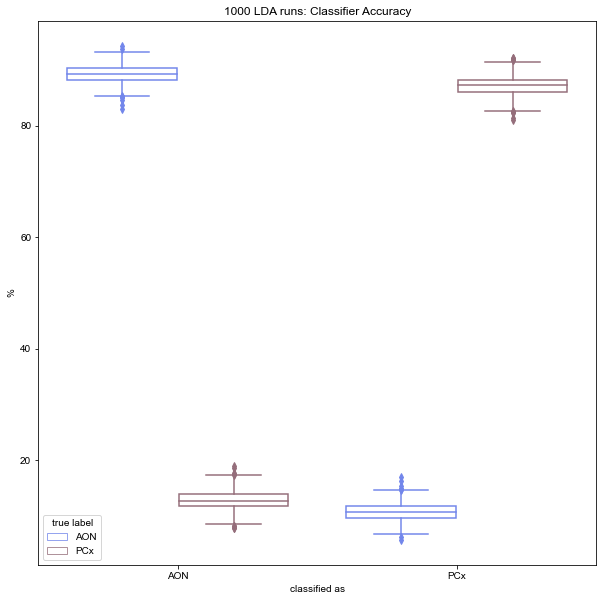

<Figure size 283.464x283.464 with 0 Axes>

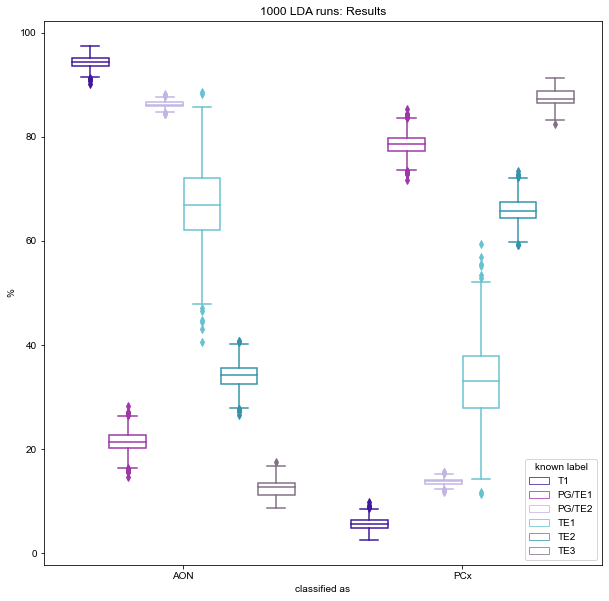

<Figure size 283.464x283.464 with 0 Axes>

In [45]:
tufted_folder = os.path.join(sim_folder,'tufted_new_colors')

st_dict = {'T1':'#3700b3',
               'PG/TE2':'#bfadeb',
                'PG/TE1':'#ae25ba',
               'TE1':'#56cfe1',
            'TE2':'#219ebc',
                'TE3':'#846b8a',}
sim_dict = {'AON' : '#5E78FF', 'PCx' : '#9C6779'}

pca_lda_quant_classifier(tufted_folder,sim_table,'general_dataset',t_table,'louvain', sim_names = ['AON','PCx'], st_names = ['T1','PG/TE1','PG/TE2','TE1','TE2','TE3'],
                         results_color=st_dict,conf_color=sim_dict,num_runs=1000)

In [ ]:
pca_lda_quant_classifier(tufted_folder,sim_table,'general_dataset',st_table,'louvain', sim_names = ['AON','PCx'], st_names = ['T-middle_1','PG/T-ext','T-ext_1','T-middle_2','T-ext_2','T-ext_3'])

In [201]:
a = pd.DataFrame(0, columns = ['a','b'], index = ['A','B'])
b = pd.DataFrame(1, columns = ['a','b'], index = ['A','B'])

In [202]:
a + b

a  b
A  1  1
B  1  1

In [203]:
from functools import reduce
d = reduce(lambda x, y: x.add(y, fill_value=0), [a,b])

In [204]:
d

a  b
A  1  1
B  1  1

## comparing pyscenic clustering to standard (move to diff notebook eventually)

In [90]:
st_table['louvain']

AAACGAAGTAGCGTCC-1    T-middle_1
AAACGCTTCCCATAAG-1    T-middle_1
AAACGCTTCTACCCAC-1       T-ext_2
AAAGAACCATCTGTTT-1    T-middle_1
AAAGGATAGCACCGTC-1    T-middle_1
                         ...    
TTTGACTCATCGGAGA-1    T-middle_1
TTTGATCAGTTGTAGA-1    T-middle_1
TTTGGTTGTGACATCT-1           M_2
TTTGTTGAGGCCTGAA-1    T-middle_1
TTTGTTGTCTCATTGT-1       T-ext_2
Name: louvain, Length: 7504, dtype: object

In [92]:
fname = '../../pyscenic_data/scanpy_clustering/alt_subclustering_pyscenic_ids.p'
scenic_table = pickle.load(open(fname,'rb'))

In [95]:
scenic_table['alt_cluster'].unique()

array(['T1b', 'M1', 'ET2', 'T1a', 'ET1', 'M2', 'ET5/PG', 'mix', 'M2/T1',
       'ET4', 'M3', 'PG'], dtype=object)

In [100]:
full_st_folder = '../../OB_single_seq_data/final_nuclei/full_tables_unscaled'
fname = os.path.join(full_st_folder,'st_data.p')
full_unscaled_matrix = pickle.load(open(fname,'rb'))

In [116]:
st_table.louvain.unique()

array(['T1', 'ET2', 'M2', 'ET5/PG', 'ET4', 'PG', 'ET1', 'M1', 'M3', 'ET3'],
      dtype=object)

In [117]:
clusters2keep = ['M1','M2','M3','T1','ET1','ET2','ET3','ET4']


names = [name for name in st_table.index if st_table.loc[name,'louvain'] in clusters2keep]

full_unscaled_matrix = st_matrix.loc[names]   


In [118]:
full_unscaled_matrix

1                   Xkr4  Gm1992  Gm37381  Rp1  Sox17  Gm37323  Mrpl15  \
AAACGAAGTAGCGTCC-1     9       5        0    0      0        0       0   
AAACGCTTCCCATAAG-1    30       0        0    0      0        0       0   
AAACGCTTCTACCCAC-1    57       2        0    0      0        0       2   
AAAGAACCATCTGTTT-1    51       4        0    0      0        0       1   
AAAGGATAGCACCGTC-1    61       2        0    0      0        0       1   
...                  ...     ...      ...  ...    ...      ...     ...   
TTTGACTCATCGGAGA-1    17       1        0    0      0        0       1   
TTTGATCAGTTGTAGA-1    26       3        0    0      0        0       0   
TTTGGTTGTGACATCT-1    36       0        0    0      0        0       0   
TTTGTTGAGGCCTGAA-1    37       2        0    0      0        0       1   
TTTGTTGTCTCATTGT-1    14       0        0    1      0        0       0   

1                   Lypla1  Gm37988  Tcea1  ...  AC125149.4  AC234645.1  \
AAACGAAGTAGCGTCC-1       0        0      0  ...           0           0   
AAACGCTTCCCATAAG-1       0        2      0  ...           0           0   
AAACGCTTCTACCCAC-1       0        0      0  ...           0           0   
AAAGAACCATCTGTTT-1       0        0      0  ...           0           0   
AAAGGATAGCACCGTC-1       0        0      0  ...           0           0   
...                    ...      ...    ...  ...         ...         ...   
TTTGACTCATCGGAGA-1       0        0      0  ...           0           0   
TTTGATCAGTTGTAGA-1       0        0      0  ...           0           0   
TTTGGTTGTGACATCT-1       0        0      2  ...           0           0   
TTTGTTGAGGCCTGAA-1       0        0      0  ...           0           0   
TTTGTTGTCTCATTGT-1       0        0      1  ...           0           0   

1                   AC168977.2  AC168977.1  AC149090.1  CAAA01118383.1  \
AAACGAAGTAGCGTCC-1           0           0          10               0   
AAACGCTTCCCATAAG-1           0           0           6               1   
AAACGCTTCTACCCAC-1           0           0           4               0   
AAAGAACCATCTGTTT-1           0           0           7               2   
AAAGGATAGCACCGTC-1           0           0          13               1   
...                        ...         ...         ...             ...   
TTTGACTCATCGGAGA-1           0           0           7               0   
TTTGATCAGTTGTAGA-1           0           0           5               2   
TTTGGTTGTGACATCT-1           0           0           1               0   
TTTGTTGAGGCCTGAA-1           0           0           5               0   
TTTGTTGTCTCATTGT-1           0           0          11               2   

1                   Vmn2r122  CAAA01147332.1  eGFP  tdtomato  
AAACGAAGTAGCGTCC-1         0               0     0         0  
AAACGCTTCCCATAAG-1         0               0     0         0  
AAACGCTTCTACCCAC-1         0               0     0         0  
AAAGAACCATCTGTTT-1         0               0     0         0  
AAAGGATAGCACCGTC-1         0               0     0         0  
...                      ...             ...   ...       ...  
TTTGACTCATCGGAGA-1         0               0     0         0  
TTTGATCAGTTGTAGA-1         0               0     0         0  
TTTGGTTGTGACATCT-1         0               0     0         0  
TTTGTTGAGGCCTGAA-1         0               0     1         0  
TTTGTTGTCTCATTGT-1         0               0     1         0  

[6472 rows x 31055 columns]

In [119]:
fname = '../../pyscenic_data/no_PG/ex_matrix.csv'
full_unscaled_matrix.to_csv(fname)

In [133]:
for i in range(0,100):
    print('python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_' + str(i) + '.csv --num_workers 50;')

python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_0.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_1.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_2.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_3.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_4.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_5.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_6.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_7.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_8.csv --num_workers 50;
python edited_arboreto.py  ex_matrix.csv  mm_tfs.txt -o 100_runs/adjacencies_9.csv --num_wo